In [349]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
# np.random.seed(46)

In [350]:
#Paramétre de la simulation
TYPE_TIRAGE = "loto" # ou "euromillion"
NB_ANNEES = 10
NB_TIRAGE_PAR_SEMAINE  = 3
PRIX_LOTO = 2.20
NB_TIRAGE_LOTO_SEMAINE = 3


#euromillion 
NB_TIRAGE_EUROMILLION_SEMAINE = 3
PRIX_EUROMILLION = 2.30



 
#Grille du joueur
GRILLE_NUMERO = [2,9,24,33,43]
GRILLE_ETOILE = [5]


#set joueur : 
grille_joueur = {"numero" :set(GRILLE_NUMERO) ,
          "etoile" : set(GRILLE_ETOILE)}


In [351]:
#calcule des gain  et des cout 

if_gain_loto = {
    "0,0":0,
    "1,0":0,
    "1,1": 2.20,
    "0,1": 2.20,
    "2,0": 4.50,
    "2,1": 11.10,
    "3,0": 18.60,
    "3,1": 50,
    "4,0": 335,
    "4,1": 817,
    "5,0": 68000,
    "5,1": 1000000
}
if_gain_euro_million = {
    "0,0":0,
    "1,0":0,
    "1,1":2.30,
    "0,1": 2.30,
    "2,0": 4.50,
    "2,1": 6.20,
    "3,0": 11.20,
    "3,1": 13.40,
    "2,2": 14.10,
    "4,0": 49.80,
    "3,2": 65.60,
    "4,1": 152.2,
    "4,2": 1773.40,
    "5,0": 23809,
    "5,1": 560301,
    "5,2": 10000000
}

def tirage_loto(numero_tirer=5,etoile_tirer=1) ->dict[str : tuple]:
    numero = np.arange(1,50)
    etoile = np.arange(1,10)
    numero = np.random.choice(numero,5,False)
    etoile = np.random.choice(etoile,1,False)    
    tirage = {"numero" : set(numero),
              "etoile" : set(etoile)}
    return tirage

def Calcule_gain_loto(numero_joueur,tirage) -> float:
    nb_numero_gagniant = len(numero_joueur["numero"].intersection((tirage["numero"])))
    nb_etoile_gagniant = len(numero_joueur["etoile"].intersection((tirage["etoile"])))
    select_gain = str(f"{nb_numero_gagniant},{nb_etoile_gagniant}")
    return if_gain_loto[select_gain] - PRIX_LOTO

def Calcule_gain_euromillion(numero_joueur,tirage) -> float:
    nb_numero_gagniant = len(numero_joueur["numero"].intersection((tirage["numero"])))  
    nb_etoile_gagniant = len(numero_joueur["etoile"].intersection((tirage["etoile"])))
    select_gain = str(f"{nb_numero_gagniant},{nb_etoile_gagniant}")
    return if_gain_euro_million[select_gain]

def tirages_loto(numero_joueur,limit_annee = 30,nombre_tirage_semaine=3)-> tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    data = []
    gain_cumuler = 0
    depense_cumuler = 0
    partie_jouer = 0
    annee = 0
    gain_semaine = 0
    jackpot = 0
    win = True
    while win and annee < limit_annee:
        # print(gain_ans)
        annee += 1
        for semaine in range(0,52):
            gain_semaine +=1
            for jour in range(0,3):
                depense_cumuler += PRIX_LOTO
                partie_jouer +=1
                tirage_n_gagniant = tirage_loto()
                jackpot =  Calcule_gain_loto(numero_joueur,tirage_n_gagniant)   
                gain_cumuler += jackpot
                data.append({
                    "Gain": jackpot,
                    "Gain_cumuler" : round(gain_cumuler,2),
                    "Depense_cumuler": round(depense_cumuler,2),
                    "Annee": annee,
                    "Semaine": gain_semaine,
                    "Numeros_joueur" : numero_joueur["numero"],
                    "Etoile_joueur" : numero_joueur["etoile"],
                    "Numero_gagnant": tirage_n_gagniant["numero"],
                    "Etoile_gagnante": tirage_n_gagniant["etoile"],
                    "Win" : jackpot>=0
                })
                if jackpot >= 100000:
                    print(jackpot)
                    win = False
    print("gain : ",gain_cumuler)
    print("depense : ",depense_cumuler)
    print("annee : ",annee)
    print("semaine : ",gain_semaine)
    print("partie jouer : ",partie_jouer)
    historique_tirage = pd.DataFrame(data)
    historique_tirage = pd.DataFrame(data).set_index("Annee")
    return  historique_tirage

gain :  -2137.20000000003
depense :  3431.9999999999154
annee :  10
semaine :  520
partie jouer :  1560


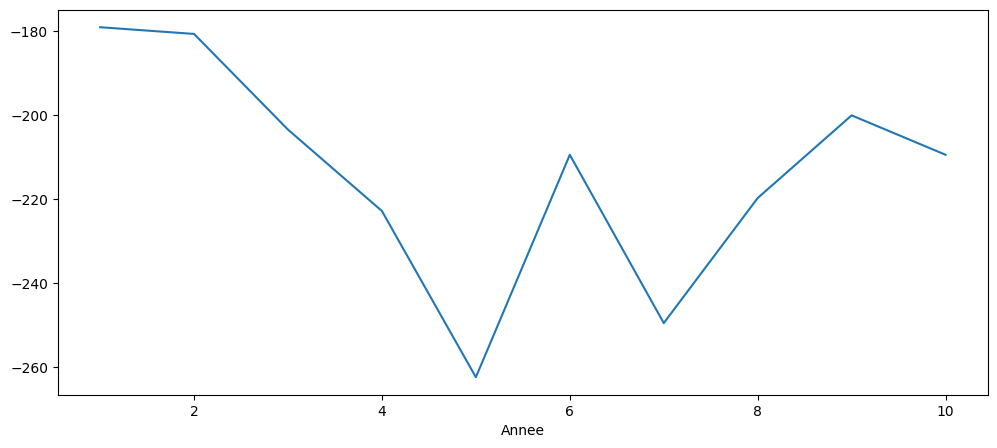

In [352]:
# Simulation
data_loto =  tirages_loto(grille_joueur,NB_ANNEES,NB_TIRAGE_PAR_SEMAINE)
data_loto.groupby("Annee")["Gain"].sum().plot(figsize=[12,5]);


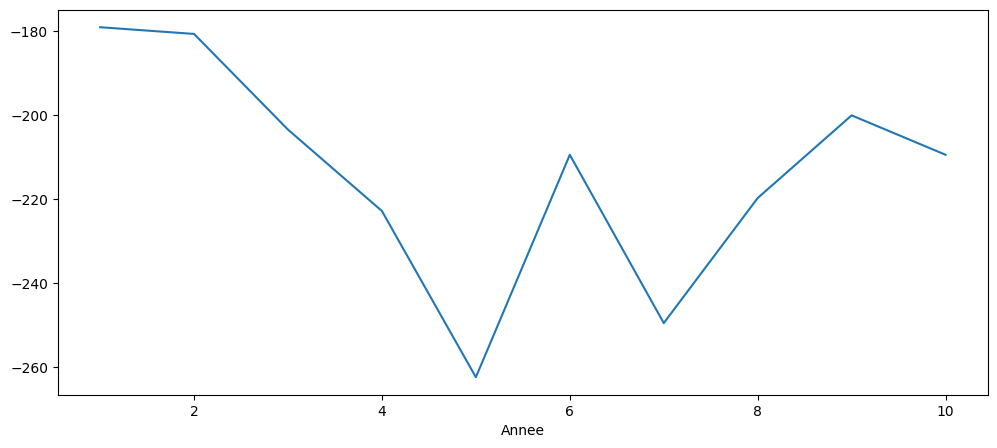

In [353]:
data_loto.groupby("Annee")["Gain"].sum().plot(figsize=[12,5]);


In [354]:
#top 10 des plus gros gros gains
data_loto.nlargest(20,"Gain").nlargest(50,"Gain")

,Gain,Gain_cumuler,Depense_cumuler,Semaine,Numeros_joueur,Etoile_joueur,Numero_gagnant,Etoile_gagnante,Win
Annee,,,,,,,,,
2,47.8,-278.7,580.8,88,"{33, 2, 9, 43, 24}",{5},"{3, 9, 43, 47, 24}",{5},True
4,16.4,-645.9,1188.0,180,"{33, 2, 9, 43, 24}",{5},"{9, 43, 20, 24, 26}",{9},True
9,16.4,-1813.8,2915.0,442,"{33, 2, 9, 43, 24}",{5},"{33, 2, 37, 44, 24}",{8},True
8,16.4,-1664.1,2655.4,403,"{33, 2, 9, 43, 24}",{5},"{2, 34, 9, 24, 29}",{4},True
6,16.4,-1216.4,2010.8,305,"{33, 2, 9, 43, 24}",{5},"{2, 36, 9, 43, 15}",{6},True
6,16.4,-1090.5,1819.4,276,"{33, 2, 9, 43, 24}",{5},"{2, 34, 43, 21, 24}",{8},True
1,16.4,-36.3,68.2,11,"{33, 2, 9, 43, 24}",{5},"{2, 7, 9, 43, 19}",{1},True
5,16.4,-945.4,1590.6,241,"{33, 2, 9, 43, 24}",{5},"{33, 4, 9, 43, 26}",{3},True
6,16.4,-1091.6,1795.2,272,"{33, 2, 9, 43, 24}",{5},"{7, 9, 43, 24, 28}",{7},True


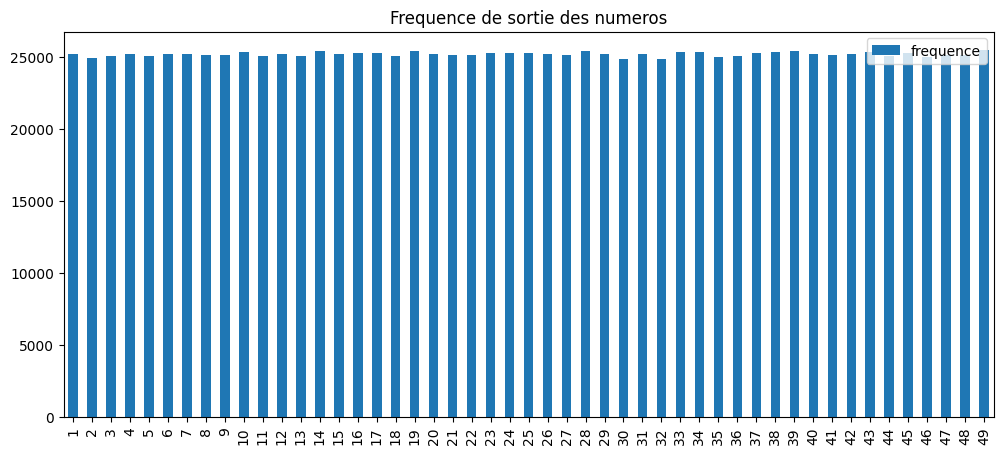

In [355]:
#frequence de sortie des numeros
data_numero_tirage.sort_index().plot(kind="bar",figsize=[12,5])
plt.title("Frequence de sortie des numeros");


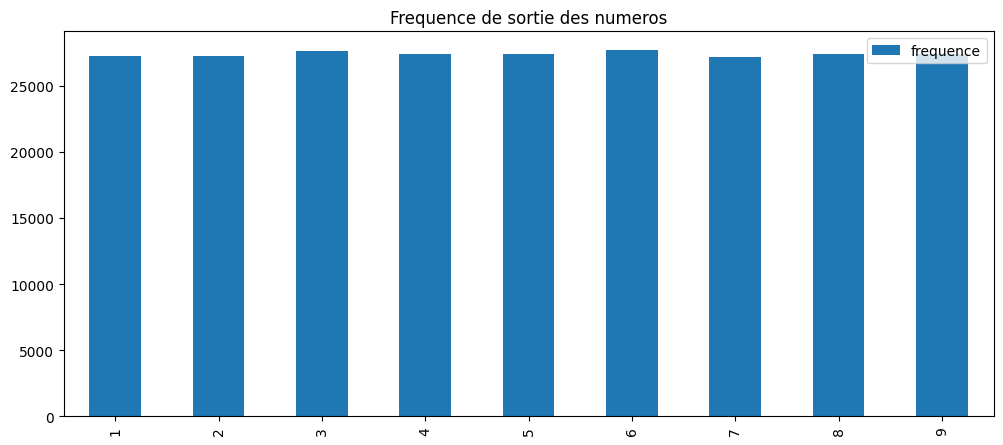

In [356]:
#frequence de sortie des etoiles
data_etoile_tirage.sort_index().plot(kind="bar",figsize=[12,5])
plt.title("Frequence de sortie des numeros");

In [357]:



 data_loto["Numero_gagnant"].apply(Counter)

Annee
1      {37: 1, 40: 1, 9: 1, 47: 1, 20: 1}
1     {33: 1, 14: 1, 21: 1, 25: 1, 27: 1}
1      {3: 1, 38: 1, 40: 1, 12: 1, 28: 1}
1      {3: 1, 13: 1, 46: 1, 15: 1, 20: 1}
1     {32: 1, 36: 1, 41: 1, 42: 1, 12: 1}
                     ...                 
10     {5: 1, 41: 1, 44: 1, 18: 1, 20: 1}
10      {1: 1, 38: 1, 9: 1, 24: 1, 25: 1}
10      {3: 1, 4: 1, 41: 1, 20: 1, 22: 1}
10     {40: 1, 8: 1, 45: 1, 23: 1, 31: 1}
10       {34: 1, 4: 1, 6: 1, 7: 1, 21: 1}
Name: Numero_gagnant, Length: 1560, dtype: object